In [1]:
import pandas as pd
import numpy as numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
from torchsummary import summary
import matplotlib.pyplot as plt
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [4]:
def train(net, train_iter, test_iter, trainer, num_epochs, device):
    train_loss = []
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        train_loss.append(train_l_sum / n)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
    return train_loss

In [5]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

In [6]:
train_data = tv.datasets.EMNIST('.', split='letters', train=True, transform=transoforms, download=True)
test_data = tv.datasets.EMNIST('.', split='letters', train=False, transform=transoforms, download=True)

In [7]:
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [8]:
train_data[0][0].shape

torch.Size([3, 224, 224])

In [10]:
train_data.classes

['N/A',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

# Модель ResNet18 

In [50]:
model = tv.models.resnet18(weights=True)

d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
summary(model.to(device), input_size=(3, 224, 224))

In [52]:
for param in model.parameters():
    param.requires_grad = False

In [53]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [54]:
model.fc = nn.Linear(in_features=512, out_features=27)

In [55]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 fc.weight
	 fc.bias


In [56]:
%env CUDA_LAUNCH_BLOCKING=1
%env TORCH_USE_CUDA_DSA=1

env: CUDA_LAUNCH_BLOCKING=1
env: TORCH_USE_CUDA_DSA=1


In [ ]:
lr, num_epochs = 0.01, 10
trainer = torch.optim.Adam(params_to_update, lr=lr)
network = train(model, train_iter, test_iter, trainer, num_epochs, device)

In [59]:
df_res = pd.DataFrame({'Loss_res': network})

df_res

,Loss_res
0,0.712833
1,0.539667
2,0.503659
3,0.485992
4,0.475368
5,0.467530
6,0.460795
7,0.455449
8,0.451231
9,0.447904


In [77]:
df_res.to_csv('resnet.csv', index= False)

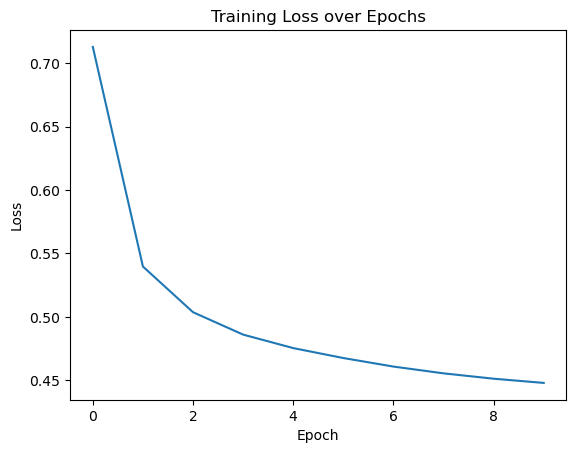

In [60]:
plt.plot(network)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Модель VGG 16

In [9]:
model = tv.models.vgg16(pretrained=True)

d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
summary(model.to(device), input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

In [11]:
for param in model.parameters():
    param.requires_grad = False


model.classifier[-1] = nn.Linear(in_features=4096, out_features=27)

In [12]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 classifier.6.weight
	 classifier.6.bias


In [ ]:
lr, num_epochs = 0.01, 10
trainer = torch.optim.Adam(params_to_update, lr=lr)
network = train(model, train_iter, test_iter, trainer, num_epochs, device)

In [14]:
df_vgg = pd.DataFrame({'Loss_vgg': network})

df_vgg

,Loss_vgg
0,1.470920
1,0.494945
2,0.400627
3,0.360682
4,0.337608
5,0.327039
6,0.317844
7,0.313864
8,0.318096
9,0.338359


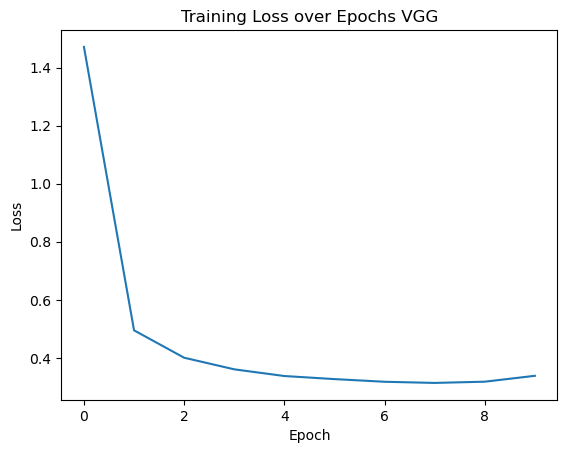

In [15]:
plt.plot(network)
plt.title('Training Loss over Epochs VGG')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Модель Inception V3

In [61]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

In [62]:
train_data = tv.datasets.EMNIST('.', split='letters', train=True, transform=transoforms, download=True)
test_data = tv.datasets.EMNIST('.', split='letters', train=False, transform=transoforms, download=True)

In [63]:
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [64]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Using cache found in C:\Users\79169/.cache\torch\hub\pytorch_vision_v0.10.0
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [65]:
summary(model.to(device), input_size=(3, 299, 299))

Layer (type:depth-idx)                   Param #
├─BasicConv2d: 1-1                       --
|    └─Conv2d: 2-1                       864
|    └─BatchNorm2d: 2-2                  64
├─BasicConv2d: 1-2                       --
|    └─Conv2d: 2-3                       9,216
|    └─BatchNorm2d: 2-4                  64
├─BasicConv2d: 1-3                       --
|    └─Conv2d: 2-5                       18,432
|    └─BatchNorm2d: 2-6                  128
├─MaxPool2d: 1-4                         --
├─BasicConv2d: 1-5                       --
|    └─Conv2d: 2-7                       5,120
|    └─BatchNorm2d: 2-8                  160
├─BasicConv2d: 1-6                       --
|    └─Conv2d: 2-9                       138,240
|    └─BatchNorm2d: 2-10                 384
├─MaxPool2d: 1-7                         --
├─InceptionA: 1-8                        --
|    └─BasicConv2d: 2-11                 --
|    |    └─Conv2d: 3-1                  12,288
|    |    └─BatchNorm2d: 3-2             128
|  

Layer (type:depth-idx)                   Param #
├─BasicConv2d: 1-1                       --
|    └─Conv2d: 2-1                       864
|    └─BatchNorm2d: 2-2                  64
├─BasicConv2d: 1-2                       --
|    └─Conv2d: 2-3                       9,216
|    └─BatchNorm2d: 2-4                  64
├─BasicConv2d: 1-3                       --
|    └─Conv2d: 2-5                       18,432
|    └─BatchNorm2d: 2-6                  128
├─MaxPool2d: 1-4                         --
├─BasicConv2d: 1-5                       --
|    └─Conv2d: 2-7                       5,120
|    └─BatchNorm2d: 2-8                  160
├─BasicConv2d: 1-6                       --
|    └─Conv2d: 2-9                       138,240
|    └─BatchNorm2d: 2-10                 384
├─MaxPool2d: 1-7                         --
├─InceptionA: 1-8                        --
|    └─BasicConv2d: 2-11                 --
|    |    └─Conv2d: 3-1                  12,288
|    |    └─BatchNorm2d: 3-2             128
|  

In [66]:
for param in model.parameters():
    param.requires_grad = False


model.fc = nn.Linear(in_features=2048, out_features=27)

In [67]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 fc.weight
	 fc.bias


In [72]:
def train_1(net, train_iter, test_iter, trainer, num_epochs, device):
    train_loss = []
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    #net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat[0], y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat[0].argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        train_loss.append(train_l_sum / n)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
    return train_loss

In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(params_to_update, lr=lr)
network = train_1(model, train_iter, test_iter, trainer, num_epochs, device)

In [70]:
df_inc = pd.DataFrame({'Loss_inc': network})

df_inc

,Loss_inc
0,1.535842
1,1.112443
2,1.047778
3,1.022650
4,1.014260
5,1.010785
6,1.004584
7,1.001751
8,1.004021
9,1.000477


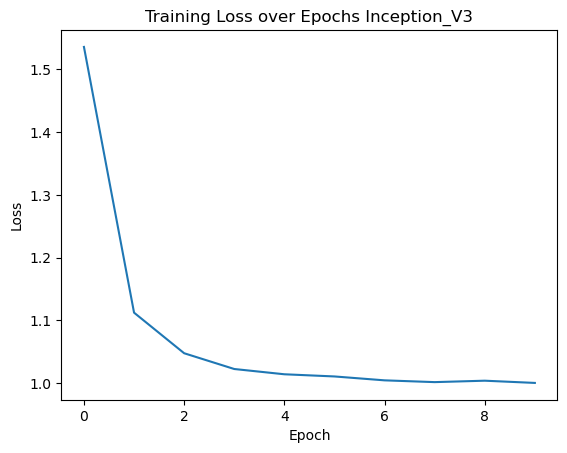

In [71]:
plt.plot(network)
plt.title('Training Loss over Epochs Inception_V3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Модель  DenseNet 161

In [32]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)

Using cache found in C:\Users\79169/.cache\torch\hub\pytorch_vision_v0.10.0
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\79169/.cache\torch\hub\checkpoints\densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:03<00:00, 31.2MB/s] 


In [42]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

In [16]:
train_data = tv.datasets.EMNIST('.', split='letters', train=True, transform=transoforms, download=True)
test_data = tv.datasets.EMNIST('.', split='letters', train=False, transform=transoforms, download=True)

In [17]:
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [45]:
summary(model.to(device), input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (14,112)
|    └─BatchNorm2d: 2-2                  (192)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             (101,952)
|    |    └─_DenseLayer: 3-2             (111,264)
|    |    └─_DenseLayer: 3-3             (120,576)
|    |    └─_DenseLayer: 3-4             (129,888)
|    |    └─_DenseLayer: 3-5             (139,200)
|    |    └─_DenseLayer: 3-6             (148,512)
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             (768)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (73,728)
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            (120,576)
|    |    └─_DenseLayer: 3-12            (129,88

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (14,112)
|    └─BatchNorm2d: 2-2                  (192)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─_DenseBlock: 2-5                  --
|    |    └─_DenseLayer: 3-1             (101,952)
|    |    └─_DenseLayer: 3-2             (111,264)
|    |    └─_DenseLayer: 3-3             (120,576)
|    |    └─_DenseLayer: 3-4             (129,888)
|    |    └─_DenseLayer: 3-5             (139,200)
|    |    └─_DenseLayer: 3-6             (148,512)
|    └─_Transition: 2-6                  --
|    |    └─BatchNorm2d: 3-7             (768)
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  (73,728)
|    |    └─AvgPool2d: 3-10              --
|    └─_DenseBlock: 2-7                  --
|    |    └─_DenseLayer: 3-11            (120,576)
|    |    └─_DenseLayer: 3-12            (129,88

In [54]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Linear(in_features=2208, out_features=27)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 classifier.weight
	 classifier.bias


In [ ]:
lr, num_epochs = 0.01, 10
trainer = torch.optim.Adam(params_to_update, lr=lr)
network = train(model, train_iter, test_iter, trainer, num_epochs)

In [56]:
df_dense = pd.DataFrame({'Loss_dense': network})

df_dense

,Loss_dense
0,0.793316
1,0.524925
2,0.503698
3,0.501309
4,0.506320
5,0.517517
6,0.517217
7,0.514475
8,0.509220
9,0.507025


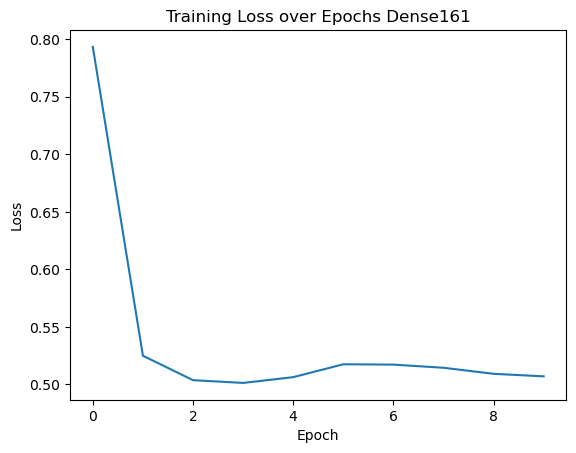

In [57]:
plt.plot(network)
plt.title('Training Loss over Epochs Dense161')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [58]:
df_res = pd.read_csv(r'C:\Users\79169\Desktop\домашка\DLL\resnet.csv')
df_res

,Loss_res
0,0.712833
1,0.539667
2,0.503659
3,0.485992
4,0.475368
5,0.467530
6,0.460795
7,0.455449
8,0.451231
9,0.447904


In [72]:
df_final = pd.concat([df_res, df_inc, df_vgg, df_dense], axis=1)
df_final

,Loss_res,Loss_inc,Loss_vgg,Loss_dense
0,0.712833,1.535842,1.470920,0.793316
1,0.539667,1.112443,0.494945,0.524925
2,0.503659,1.047778,0.400627,0.503698
3,0.485992,1.022650,0.360682,0.501309
4,0.475368,1.014260,0.337608,0.506320
5,0.467530,1.010785,0.327039,0.517517
6,0.460795,1.004584,0.317844,0.517217
7,0.455449,1.001751,0.313864,0.514475
8,0.451231,1.004021,0.318096,0.509220
9,0.447904,1.000477,0.338359,0.507025


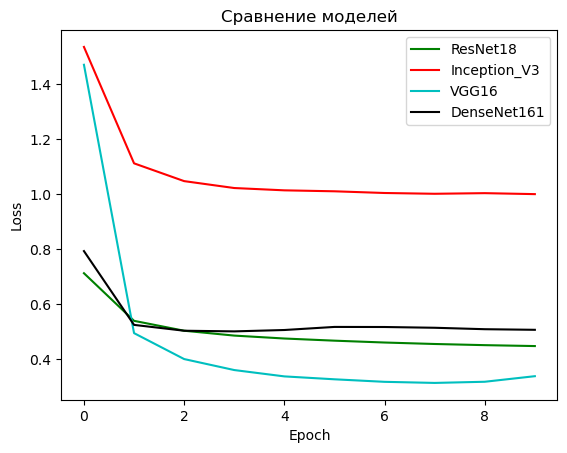

In [77]:
plt.plot(df_final['Loss_res'], '-g', label='ResNet18')
plt.plot(df_final['Loss_inc'], '-r', label='Inception_V3')
plt.plot(df_final['Loss_vgg'], '-c', label='VGG16')
plt.plot(df_final['Loss_dense'], '-k', label='DenseNet161')
plt.legend()
plt.title('Сравнение моделей')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Датасет hymenoptera_data

Модель ResNet18

In [231]:
BATCH_SIZE = 8
transoforms = tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

In [232]:
data_dir = r'C:\Users\79169\Desktop\домашка\DLL\hymenoptera_data'

In [233]:
train_data = tv.datasets.ImageFolder(data_dir + '/train', transoforms)
test_data = tv.datasets.ImageFolder(data_dir + '/val', transoforms)

train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [234]:
model = tv.models.resnet18(weights=True)

d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [235]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(in_features=512, out_features=2)

In [236]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 fc.weight
	 fc.bias


In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(params_to_update, lr=lr)
network = train(model, train_iter, test_iter, trainer, num_epochs, device)

In [238]:
df_res = pd.DataFrame({'Loss_res': network})

df_res

,Loss_res
0,0.609551
1,0.302142
2,0.198976
3,0.152918
4,0.122258
5,0.102634
6,0.099254
7,0.090897
8,0.067062
9,0.058984


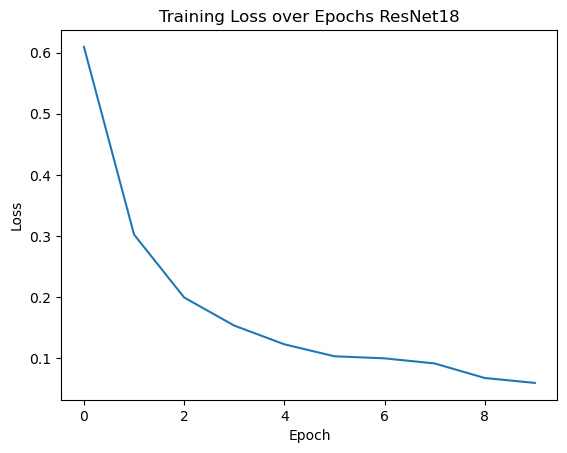

In [239]:
plt.plot(network)
plt.title('Training Loss over Epochs ResNet18')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Модель VGG16

In [240]:
model = tv.models.vgg16(pretrained=True)

d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [241]:
for param in model.parameters():
    param.requires_grad = False


model.classifier[-1] = nn.Linear(in_features=4096, out_features=2)

In [242]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 classifier.6.weight
	 classifier.6.bias


In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(params_to_update, lr=lr)
network = train(model, train_iter, test_iter, trainer, num_epochs, device)

In [244]:
df_vgg = pd.DataFrame({'Loss_vgg': network})

df_vgg

,Loss_vgg
0,0.454884
1,0.169315
2,0.106914
3,0.071213
4,0.052285
5,0.046276
6,0.033366
7,0.030355
8,0.022967
9,0.019076


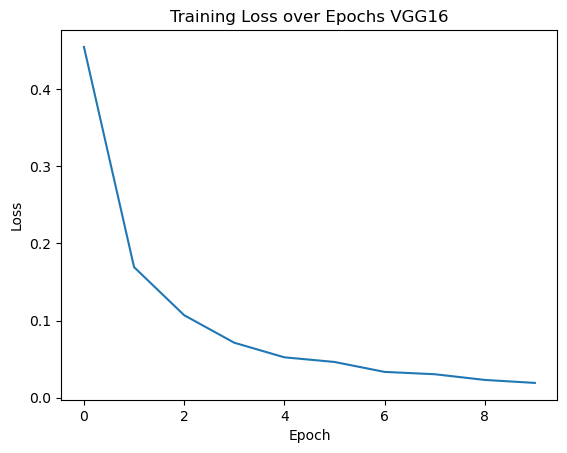

In [245]:
plt.plot(network)
plt.title('Training Loss over Epochs VGG16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Модель Inception_V3

In [205]:
BATCH_SIZE = 8
transforms = tv.transforms.Compose([
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

In [206]:
data_dir = r'C:\Users\79169\Desktop\домашка\DLL\hymenoptera_data'

In [217]:
train_data = tv.datasets.ImageFolder(data_dir + '/train', transform=transforms)
test_data = tv.datasets.ImageFolder(data_dir + '/val', transform=transforms)

train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [218]:
train_data[0][0].shape

torch.Size([3, 299, 299])

In [220]:
model = tv.models.inception_v3(pretrained=True)

In [221]:
for param in model.parameters():
    param.requires_grad = False


model.fc = nn.Linear(in_features=2048, out_features=2)

In [223]:
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 fc.weight
	 fc.bias


In [227]:
def train_1(net, train_iter, test_iter, trainer, num_epochs, device):
    train_loss = []
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    #net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat[0], y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat[0].argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. " 
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        train_loss.append(train_l_sum / n)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
    return train_loss

In [226]:
for name, layer in model.named_children():
    if isinstance(layer, nn.Conv2d):
        print(f"{name}: {layer}")

In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(params_to_update, lr=lr)
network = train_1(model, train_iter, test_iter, trainer, num_epochs, device)

In [229]:
df_inc = pd.DataFrame({'Loss_inc': network})

df_inc

,Loss_inc
0,0.613919
1,0.428366
2,0.368501
3,0.298560
4,0.338162
5,0.284948
6,0.289928
7,0.361580
8,0.322178
9,0.239690


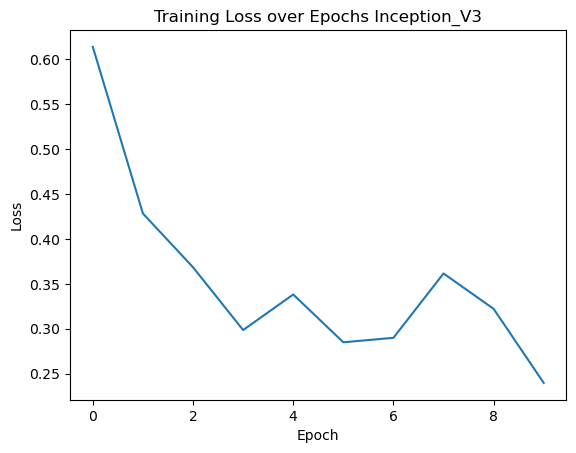

In [230]:
plt.plot(network)
plt.title('Training Loss over Epochs Inception_V3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Модель DenseNet161

In [246]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)

Using cache found in C:\Users\79169/.cache\torch\hub\pytorch_vision_v0.10.0
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [247]:
BATCH_SIZE = 8
transoforms = tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])

In [248]:
data_dir = r'C:\Users\79169\Desktop\домашка\DLL\hymenoptera_data'
train_data = tv.datasets.ImageFolder(data_dir + '/train', transform=transforms)
test_data = tv.datasets.ImageFolder(data_dir + '/val', transform=transforms)

In [249]:
train_iter = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [250]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Linear(in_features=2208, out_features=2)
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 classifier.weight
	 classifier.bias


In [ ]:
lr, num_epochs = 0.001, 10
trainer = torch.optim.Adam(params_to_update, lr=lr)
network = train(model, train_iter, test_iter, trainer, num_epochs, device)

In [263]:
df_dense = pd.DataFrame({'Loss_dense': network})

df_dense

,Loss_dense
0,5.946891
1,0.060411
2,0.009097
3,0.005022
4,0.003607
5,0.002879
6,0.002465
7,0.002219
8,0.002069
9,0.001974


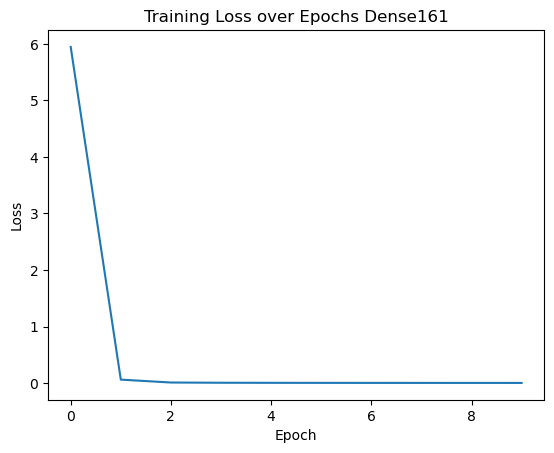

In [264]:
plt.plot(network)
plt.title('Training Loss over Epochs Dense161')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [265]:
df_final = pd.concat([df_res, df_inc, df_vgg, df_dense], axis=1)
df_final

,Loss_res,Loss_inc,Loss_vgg,Loss_dense
0,0.609551,0.613919,0.454884,5.946891
1,0.302142,0.428366,0.169315,0.060411
2,0.198976,0.368501,0.106914,0.009097
3,0.152918,0.298560,0.071213,0.005022
4,0.122258,0.338162,0.052285,0.003607
5,0.102634,0.284948,0.046276,0.002879
6,0.099254,0.289928,0.033366,0.002465
7,0.090897,0.361580,0.030355,0.002219
8,0.067062,0.322178,0.022967,0.002069
9,0.058984,0.239690,0.019076,0.001974


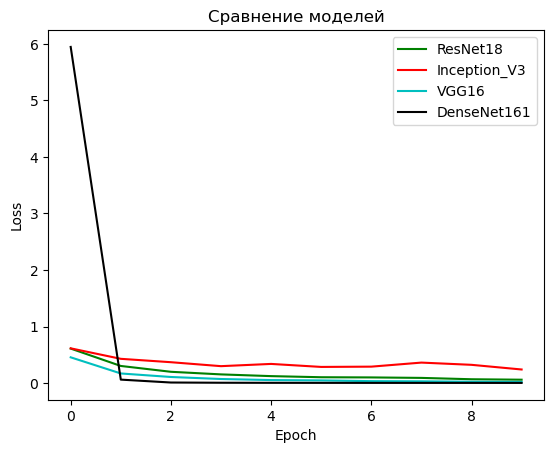

In [266]:
plt.plot(df_final['Loss_res'], '-g', label='ResNet18')
plt.plot(df_final['Loss_inc'], '-r', label='Inception_V3')
plt.plot(df_final['Loss_vgg'], '-c', label='VGG16')
plt.plot(df_final['Loss_dense'], '-k', label='DenseNet161')
plt.legend()
plt.title('Сравнение моделей')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()